# pyrolite: alphaMELTS Interface

**Intro** [Start](0.0_StartHere.ipynb) • [Intro](1.1_Introduction.ipynb)
<br> **pyrolite** [Geochem](2.1_pyroliteGeochem.ipynb) • [Visualisation](2.2_pyroliteVis.ipynb) • <mark>[alphaMELTS](2.3_pyroliteMELTS.ipynb)</mark > • [lambdas](2.4_lambdas.ipynb) <br>  **Comparative Geochem**  [Databases, Data Mining and Deriving Context](3.1_ComparativeGeochemData.ipynb)<br>  **Machine Learning** [Intro](4.0_MachineLearning.ipynb) • [Features](4.1_Features.ipynb)• [High-D Vis](4.3_HighDVis.ipynb) • [Classification](4.4_Classification.ipynb) • [Regression & Prediction](4.5_Regression.ipynb) • [Clustering](4.6_Clustering.ipynb) <br>  **GitHub** [geochem4nickel](https://github.com/morganjwilliams/geochem4nickel) • [pyrolite](https://github.com/morganjwilliams/pyrolite)

#### <i class="fa fa-twitter" aria-hidden="true"><a href="https://twitter.com/metasomite" style="font-family:Courier New,Courier,Lucida Sans Typewriter,Lucida Typewriter,monospace;"> @metasomite</a></i>

pyrolite includes an interface for working with [alphaMELTS](https://magmasource.caltech.edu/alphaMELTS/). Through this, you can conduct melting experiments, access the output data and quickly visualise the results. It was designed for repeatedly running melts on over a grid of compositions, pressures and temperatures. This notebook demonstrates part of that capability, and some of the ways in which this interface could be used.

<div class="alert alert-info">
  This interface is in an <code>alpha</code> stage. It will soon be split from the pyrolite project into its own repository.
</div>

This exercise sets up an alphaMELTS isobaric crystallisation experiment using a MORB composition which is 'blurred' to generate a montecarlo simulation of the impact of compositional uncertainty on fractionation model outputs.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import pyrolite.geochem
import pyrolite.plot
from pyrolite.comp.codata import ilr, inverse_ilr
from pyrolite.util.meta import stream_log
import logging

logger = logging.Logger(__name__)
stream_log(logger)  # print the logging output

<Logger __main__ (INFO)>

In [2]:
def blur_compositions(df, noise=0.05, scale=100):
    """
    Function to add 'compositional noise' to a set of compositions. In reality, it's
    its best to use measured uncertainties to generate these simulated compositions.
    """
    # transform into compositional space, add noise, return to simplex
    xvals = ilr(df.values)
    xvals += np.random.randn(*xvals.shape) * noise
    return inverse_ilr(xvals) * scale

In [3]:
from pyrolite.geochem.norm import get_reference_composition

# get the major element composition of MORB from Gale et al (2013)
Gale_MORB = get_reference_composition("MORB_Gale2013")
MORB = Gale_MORB.comp.pyrochem.oxides.reset_index(drop=True)

In [4]:
MORB["Title"] = Gale_MORB.name
MORB["Initial Temperature"] = 1300
MORB["Final Temperature"] = 800
MORB["Initial Pressure"] = 5000
MORB["Final Pressure"] = 5000
MORB["Log fO2 Path"] = "FMQ"
MORB["Increment Temperature"] = -5
MORB["Increment Pressure"] = 0

In [6]:
from pyrolite.util.text import slugify
from pyrolite.util.pd import accumulate

reps = 10
df = accumulate([MORB] * reps)
df = df.reset_index().drop(columns="index")
df[df.pyrochem.list_oxides] = (
    df.loc[:, df.pyrochem.list_oxides].astype(float).pyrocomp.renormalise()
)
df[df.pyrochem.list_oxides] = blur_compositions(df[df.pyrochem.list_oxides])
df.Title = df.Title + " " + df.index.map(str)  # differentiate titles
df.Title = df.Title.apply(slugify)

In [8]:
from pyrolite.ext.alphaMELTS.env import MELTS_Env

env = MELTS_Env()
env.VERSION = "MELTS"  # crustal processes, < 1GPa/10kbar
env.MODE = "isobaric"
env.DELTAT = -5
env.MINP = 0
env.MAXP = 10000

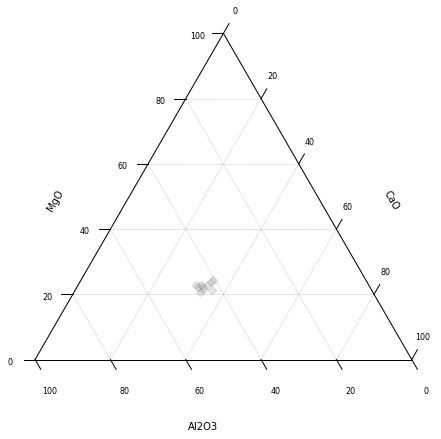

In [9]:
ax = df.loc[:, ["CaO", "MgO", "Al2O3"]].pyroplot.ternary(alpha=0.2, c="0.5")

In [10]:
from pyrolite.ext.alphaMELTS.automation import MeltsBatch

# create a directory to run this experiment in
tempdir = Path("./") / "montecarlo"

batch = MeltsBatch(
    df,
    default_config={
        "Initial Pressure": 5000,
        "Initial Temperature": 1300,
        "Final Temperature": 800,
        "modes": ["isobaric"],
    },
    grid={
        # "Initial Pressure": [3000, 7000],
        # "Log fO2 Path": [None, "FMQ"],
        # "modifychem": [None, {"H2O": 0.5}],
    },
    env=env,
    logger=logger,
    fromdir=tempdir,
)

batch.grid

[{}, {'Log fO2 Path': 'FMQ'}]

Now we can run the calculations. Note that this can take a while, especially when the experiments themselves proceed to lower temperatures. 

In [11]:
batch.run(
    overwrite=True
)  # overwrite=False if you don't want to update existing exp folders

__main__ - INFO - Starting 2 Calculations for 10 Compositions.
__main__ - INFO - Estimated Time: 0:02:00
__main__ - INFO - 100%|##########| 2/2 [06:36<00:00, 198.80s/it]
__main__ - INFO - Calculations Complete after 0:06:36.821714


Now the calculations are complete, we can bring the results together for visualisation and analysis. Normally, this would involve moving data from the alphaMELTS table outputs themselves, but pyrolite has a few handy functions for bringing in this data and creating some common visualisations.

In [12]:
from pathlib import Path
from pyrolite.ext.alphaMELTS.tables import get_experiments_summary
from pyrolite.ext.alphaMELTS.plottemplates import table_by_phase

tempdir = Path("./") / "montecarlo"

summary = get_experiments_summary(tempdir / "isobar5kbar1300-800C", kelvin=False)

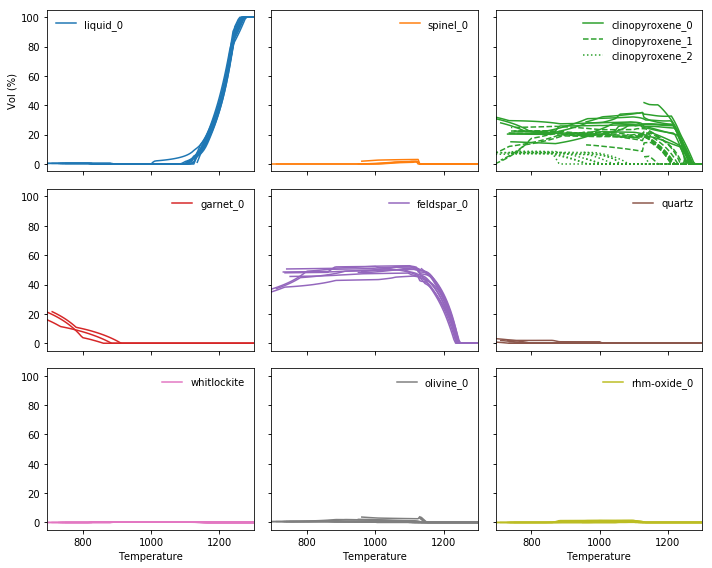

In [17]:
table_by_phase(summary, table="phasevol", plotswide=3, figsize=(10, 8))

Next: [Lambas: Parameterisation and Dimensional Reduction of REE Data](2.4_lambdas.ipynb)